# How to correct for PCR bias in RNA expriment
Andrew E. Davidson  
aedavids@ucsc.edu  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0


## Abstract
PCR and cDNA are common methods. In general amplification is a valid method in
- transfomation and transfection
  * we have very small sequence we wish to clone
  * we want to create as many templates as possible
- DNA sequencing (Shotgun sequencing)
  * DNA is double stranded
  * we can assume the fragment counts are uniformaly distributed. I.e. if we ignore repeats a fragment may occur at most twice

PCR introduces signfigant bias into RNA experiments that is not corrected in current RNA normalization methods. We know that many factors including cell type, environment, diease, behavior affect RNA to expression level. Repeated thermo cycling create probablity distrbution that are heavly biased toward high count gene expression levels in the original sample.

### Table of Contents
- simulated PCR data
    * see cell [6] figure "Effect of PCR cycling on transcript count distribution"
- overview of DESeq Normalization
    * see cell [7]
    * This is what we use
- Evaluate normalization on PCR products cell [12]
  * it does not work
 - Correcting for PCR Bias cell [16]
 - Experimental Design cell[19]

In [1]:
import ipynbname
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

outDir = f'{notebookDir}/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

outDir:
/private/home/aedavids/extraCellularRNA/juypterNotebooks/correctPCRBiasInRNAExperiments.out

imgOut :
/private/home/aedavids/extraCellularRNA/juypterNotebooks/correctPCRBiasInRNAExperiments.out/img


/data/tmp/ipykernel_2804566/2839616518.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = os.environ['PYTHONPATH']
print("ORIG_PYTHONPATH: {}\n".format(PYTHONPATH))

gitRepoRoot = !git rev-parse --show-toplevel
gitRepoRoot = gitRepoRoot[0]

#
# add deconvolutionAnalysis modules
#
deconvolutionModules = f'{gitRepoRoot}/deconvolutionAnalysis/python'
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = PYTHONPATH + f':{deconvolutionModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(deconvolutionModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

ORIG_PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src

deconvolutionModules: /private/home/aedavids/extraCellularRNA/deconvolutionAnalysis/python



In [3]:
from pipeline.dataFactory.utilities import urlify

## Simulated PCR data

In [4]:
transcriptCountsNP = np.array( 
                    [
                        np.power( [2, 4, 8, 16], 1),
                        np.power( [2, 4, 8, 16], 2),
                        np.power( [2, 4, 8, 16], 3),
                        np.power( [2, 4, 8, 16], 4),

                    ])
transcriptCountCols = ["g1", "g2", "g3", "g4"]
PCR_transcriptCountsDF = pd.DataFrame( 
                    transcriptCountsNP, 
                    index = ["groundTruth", "cycle1", "cycle2", "cycle3"],
                    columns = transcriptCountCols
                 )

PCR_transcriptCountsDF

,g1,g2,g3,g4
groundTruth,2,4,8,16
cycle1,4,16,64,256
cycle2,8,64,512,4096
cycle3,16,256,4096,65536


In [5]:
byCols = 1
rowSumsSeries = PCR_transcriptCountsDF.sum(axis=byCols) 
byIndex = 0
propDistributionDF = PCR_transcriptCountsDF.loc[:, transcriptCountCols].div( rowSumsSeries, axis=byIndex )

propDistributionDF

,g1,g2,g3,g4
groundTruth,0.066667,0.133333,0.266667,0.533333
cycle1,0.011765,0.047059,0.188235,0.752941
cycle2,0.001709,0.013675,0.109402,0.875214
cycle3,0.000229,0.003662,0.058595,0.937514


saved image to /private/home/aedavids/extraCellularRNA/juypterNotebooks/correctPCRBiasInRNAExperiments.out/imgEffect-of-PCR-cycling-on-transcript-count-distribution.png


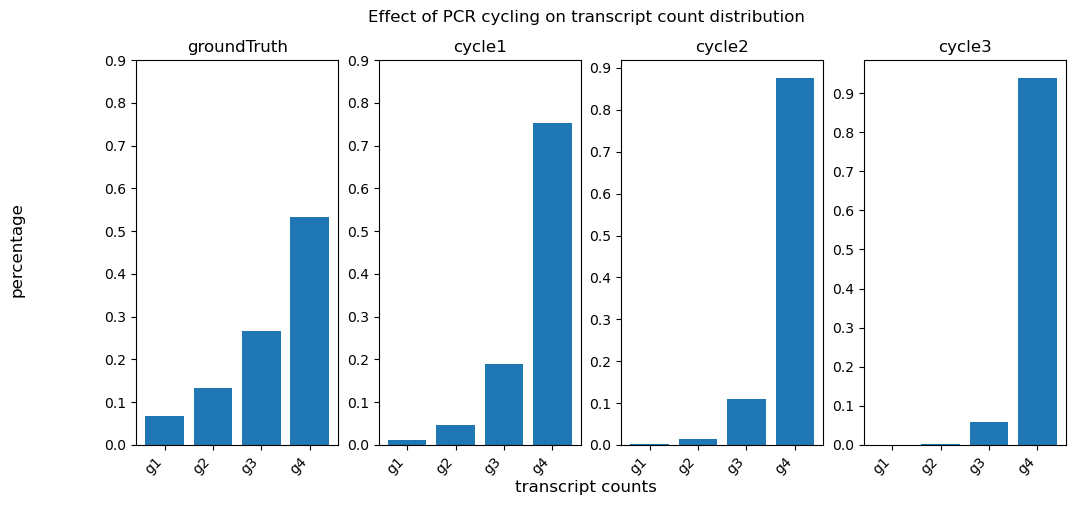

In [6]:
w = 12
h = 5
numCycles = len( propDistributionDF.index )
fig, axs = plt.subplots(nrows=1, ncols=numCycles, figsize=(w, h), ) #sharey=True
labels = propDistributionDF.columns

for i in range(0, numCycles):
    panel = axs[i]
    panel.set_title(  propDistributionDF.index[i] )
    values = propDistributionDF.iloc[i, :]
    panel.bar(labels, values )
    panel.set_xticks(panel.get_xticks(), panel.get_xticklabels(), rotation=45, ha='right')
    ylabels = np.arange(0, 1, 0.1)
    panel.set_yticks(ylabels)

    # panel.set_title('max_samples' + " " + metricName, fontsize=fs)
    #panel.set_title( metricName, fontsize=fs)

title = "Effect of PCR cycling on transcript count distribution"
fig.suptitle(title)
fig.supylabel('percentage')
fig.supxlabel('transcript counts')

imgFilePath = imgOut + urlify(title) + ".png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

# Normalization Overiew

In [7]:
def calculateScalingFactor(intensityDF : pd.DataFrame,
                          verbose : bool = False) -> pd.Series :
    # print("\n********** intensity")
    # print(intensityDF)
    
    # remove rows with zeros. log is undefined
    byRows = 1
    selectRowsWithoutZeros = (intensityDF != 0).all(axis=byRows)
    if verbose:
        print("\n********** selectRowsWithoutZeros")
        display(selectRowsWithoutZeros)
    
    intensityDF = intensityDF.loc[selectRowsWithoutZeros, :]
    if verbose:
        print("\n********** intensity")
        print(intensityDF)
    
    # natural log
    # smooths over outliers
    logIntensityDF = np.log(intensityDF)
    if verbose:
        print("\n************ logIntensityDF ")
        display(logIntensityDF)   
    
    # calculate row average of logs. ie geometric means
    # geometric mean is not swayed by outliers. It will 
    # always be <= the arithmetic mean
    rowMeansSeries = logIntensityDF.mean(axis=byRows)
    if verbose:
        print("\n************ rowMeansSeries ")
        display(rowMeansSeries)   
    
    # find metabolites that are signifigantly larger or smaller than 
    # the average subtracting averages from intensities
    # log(a) - log(b) = log(a/b)
    byCols= 0
    outlierDF = logIntensityDF.subtract(rowMeansSeries, axis=byCols)
    if verbose:
        print("\n************ outlierDF ")
        print(type(outlierDF))
        display(outlierDF)   
    
    # calculate the scan/sample median log(estimated scaling factors)
    medianDF = outlierDF.median(axis=byCols)
    if verbose:
        print("\n************ medianDF ")
        print(type(medianDF))
        display(medianDF)      
    
    # convert back to base 10
    extimatedScalingFactorsSeries = np.exp(medianDF)
    # print("\n************ extimatedScalingFactorsSeries ")
    # print(type(extimatedScalingFactorsSeries))
    # display(extimatedScalingFactorsSeries)  
    
    return extimatedScalingFactorsSeries

## Case 1 : Library Size Normalization
No biologic difference between samples. Experiments designed to create different number of reads

In [8]:
def createLibSizeTestData() -> pd.DataFrame :
    '''
    The samples are identical. The only different was number of reads produced
    '''
    readsNP = np.array([30, 24, 0, 563, 5, 13]).reshape(6,1)

    byCols = 1
    countsNP = np.append(readsNP, 
                        readsNP * 2., 
                        axis=byCols)

    # use a data frame to make it easier to understand the data
    retDF = pd.DataFrame(countsNP, 
                             columns=["replicate1", "replicate2"],
                             index = ["transcript1", 
                                      "transcript2", 
                                      "transcript3", 
                                      "transcript4", 
                                      "transcript5",
                                      "transcript6",
                                     ])
                         
    return retDF
    
libSizeTestcountsDF = createLibSizeTestData()
libSizeTestcountsDF

,replicate1,replicate2
transcript1,30.0,60.0
transcript2,24.0,48.0
transcript3,0.0,0.0
transcript4,563.0,1126.0
transcript5,5.0,10.0
transcript6,13.0,26.0


In [9]:
def testLibarySizeNormalization():
    libSizeTestcountsDF = createLibSizeTestData()
    print("**** raw counts")
    display(libSizeTestcountsDF)
    
    extimatedScalingFactorsSeries = calculateScalingFactor(libSizeTestcountsDF)
    print(f'extimatedScalingFactorsSeries :\n{extimatedScalingFactorsSeries}')
    
    normalizedDF = libSizeTestcountsDF / extimatedScalingFactorsSeries
    
    print("\n**** normalized counts. replicate1 and replicate2 should be identical")
    display(normalizedDF)
    #display(np.isclose(normalizedDF['scan1'], normalizedDF['scan2']))
    np.testing.assert_allclose( normalizedDF['replicate1'],
                                normalizedDF['replicate2'],
                                err_msg="ERROR testLibarySizeNormalization() failed ") 

testLibarySizeNormalization()

**** raw counts


,replicate1,replicate2
transcript1,30.0,60.0
transcript2,24.0,48.0
transcript3,0.0,0.0
transcript4,563.0,1126.0
transcript5,5.0,10.0
transcript6,13.0,26.0


extimatedScalingFactorsSeries :
replicate1    0.707107
replicate2    1.414214
dtype: float64

**** normalized counts. replicate1 and replicate2 should be identical


,replicate1,replicate2
transcript1,42.426407,42.426407
transcript2,33.941125,33.941125
transcript3,0.000000,0.000000
transcript4,796.202236,796.202236
transcript5,7.071068,7.071068
transcript6,18.384776,18.384776


## Case 2: Library Compositions
Samples are biologically different. One sample has more targets. This causes the sample with fewer samples to have arifically high counts.

Example: 
- A drop out expereiment
- RNA collected from different cell types

In [10]:
def createLibCompositionTestData() -> pd.DataFrame :
    '''
    step 1)
    Create two samples. One sample represents a health control, the other a toxic exposure.
    The only difference is the sample with the toxic exposure has an additional target
    
    To make it easy to evaluate the normlization algorithym the toxic's target has a very high intensity
    
    step 2) simulate the raw intensities
    both sample will contain the same number of ions.
    '''
    tokinIntensity = 563
    toxinIntensityNP = np.array([30, 24, 0, tokinIntensity, 5, 13]).reshape(6,1)
    # print(f'\n****** total intensity\n{np.sum(toxinIntensityNP)}')
    
    # normal is missing toxin_a_mz_103, idx = 3
    # simulate where extra 563 ions will be distributed
    controlIntensityNP = np.array([30, 24, 0, 0, 5, 13]).reshape(6,1)
    propDistNP = (controlIntensityNP / np.sum(controlIntensityNP)).reshape(1,6)
    #print(f'\n****** propDistNP\n{propDistNP}')
    
    intensity = tokinIntensity * propDistNP
    # print(f'\n****** intensity\n{intensity}')
    # print(np.sum(intensity))
    
    controlRawIntensity = controlIntensityNP  + intensity.reshape(6,1)
    # print(f'\n****** controlRawIntensity\n{controlRawIntensity}')
    # print(np.sum(controlRawIntensity))

    byCols = 1
    scansNP = np.append(toxinIntensityNP, 
                        controlRawIntensity, 
                        axis=byCols)

    # use a data frame to make it easier to under the data
    retDF = pd.DataFrame(scansNP, 
                             columns=["sample1", "sample2"],
                             index = ["metabolite_1_mz_34.5", 
                                      "metabolite_2_mz_67.0", 
                                      "metabolite_3_mz_89.5", 
                                      "toxin_a_mz_103.1", 
                                      "metabolite_5_mz_121.5",
                                      "metabolite_6_mz_137.5",
                                     ])
                         
    return retDF

createLibCompositionTestData()

,sample1,sample2
metabolite_1_mz_34.5,30.0,264.583333
metabolite_2_mz_67.0,24.0,211.666667
metabolite_3_mz_89.5,0.0,0.000000
toxin_a_mz_103.1,563.0,0.000000
metabolite_5_mz_121.5,5.0,44.097222
metabolite_6_mz_137.5,13.0,114.652778


In [11]:
def testLibaryCompisionNormalization():
    rawIntensitiesDF = createLibCompositionTestData()
    print("**** raw intensities")
    display(rawIntensitiesDF)
    
    extimatedScalingFactorsSeries = calculateScalingFactor(rawIntensitiesDF)
    print("\n**** extimatedScalingFactorsSeries")
    display(extimatedScalingFactorsSeries)
    
    normalizedDF = rawIntensitiesDF / extimatedScalingFactorsSeries
    print("\n**** normalized intensities")
    print("target found in boths samples should have identical intensities")
    display(normalizedDF)
    
    # test the intersection of mz targets is the same after normalization
    byRows = 1
    selectRowsWithoutZeros = (normalizedDF != 0).all(axis=byRows)
    testResultsDF = normalizedDF.loc[selectRowsWithoutZeros, :]
    np.testing.assert_allclose( testResultsDF['sample1'],
                                testResultsDF['sample2'],
                                err_msg="ERROR testLibaryCompisionNormalization() failed ")     

testLibaryCompisionNormalization()

**** raw intensities


,sample1,sample2
metabolite_1_mz_34.5,30.0,264.583333
metabolite_2_mz_67.0,24.0,211.666667
metabolite_3_mz_89.5,0.0,0.000000
toxin_a_mz_103.1,563.0,0.000000
metabolite_5_mz_121.5,5.0,44.097222
metabolite_6_mz_137.5,13.0,114.652778



**** extimatedScalingFactorsSeries


sample1    0.336728
sample2    2.969755
dtype: float64


**** normalized intensities
target found in boths samples should have identical intensities


,sample1,sample2
metabolite_1_mz_34.5,89.092648,89.092648
metabolite_2_mz_67.0,71.274119,71.274119
metabolite_3_mz_89.5,0.000000,0.000000
toxin_a_mz_103.1,1671.972035,0.000000
metabolite_5_mz_121.5,14.848775,14.848775
metabolite_6_mz_137.5,38.606814,38.606814


# Evaluate normalization on PCR products

In [12]:
def testPCRNormalization(df : pd.DataFrame, 
                         idx1 : str, 
                         idx2 : str) -> bool :
    '''
    TODO
    '''
    testDF =  PCR_transcriptCountsDF.loc[ [idx1, idx2] ]
    extimatedScalingFactorsSeries = calculateScalingFactor( testDF )
    print(f'extimatedScalingFactorsSeries :\n{extimatedScalingFactorsSeries}')

    print("\n**** normalized counts. replicate1 and replicate2 should be identical")    
    normalizedDF = testDF / extimatedScalingFactorsSeries
    display(normalizedDF)

    isEqual = normalizedDF.loc[idx1, :] == normalizedDF.loc[idx2, :]

    if isEqual.all()  :
        ret = True
        print(f'test passed: replicants are identical')
    else:
        ret = False
        print(f'test failed: replicants are not identical')

    return ret

In [13]:
testPCRNormalization(PCR_transcriptCountsDF, "groundTruth",  "cycle1")

extimatedScalingFactorsSeries :
g1    0.210224
g2    0.594604
g3    1.681793
g4    4.756828
dtype: float64

**** normalized counts. replicate1 and replicate2 should be identical


,g1,g2,g3,g4
groundTruth,9.513657,6.727171,4.756828,3.363586
cycle1,19.027314,26.908685,38.054628,53.817371


test failed: replicants are not identical


False

In [14]:
testPCRNormalization(PCR_transcriptCountsDF,  "cycle1" , "cycle2")

extimatedScalingFactorsSeries :
g1     0.074325
g2     0.420448
g3     2.378414
g4    13.454343
dtype: float64

**** normalized counts. replicate1 and replicate2 should be identical


,g1,g2,g3,g4
cycle1,53.817371,38.054628,26.908685,19.027314
cycle2,107.634741,152.218511,215.269482,304.437021


test failed: replicants are not identical


False

In [15]:
testPCRNormalization(PCR_transcriptCountsDF,  "cycle2" , "cycle3")

extimatedScalingFactorsSeries :
g1     0.026278
g2     0.297302
g3     3.363586
g4    38.054628
dtype: float64

**** normalized counts. replicate1 and replicate2 should be identical


,g1,g2,g3,g4
cycle2,304.437021,215.269482,152.218511,107.634741
cycle3,608.874043,861.077929,1217.748086,1722.155858


test failed: replicants are not identical


False

# Correcting for PCR Bias
We can correct for PCR bias by taking the nth root of our transcript counts, where n is the number of thermo cycles

In [16]:
PCR_transcriptCountsDF.loc[ 'groundTruth', :].pow(1/1)

g1     2.0
g2     4.0
g3     8.0
g4    16.0
Name: groundTruth, dtype: float64

In [17]:
PCR_transcriptCountsDF.loc[ 'cycle1', :].pow(1/2)

g1     2.0
g2     4.0
g3     8.0
g4    16.0
Name: cycle1, dtype: float64

In [18]:
PCR_transcriptCountsDF.loc[ 'cycle2', :].pow(1/3)

g1     2.0
g2     4.0
g3     8.0
g4    16.0
Name: cycle2, dtype: float64

In [19]:
PCR_transcriptCountsDF.loc[ 'cycle3', :].pow(1/4)

g1     2.0
g2     4.0
g3     8.0
g4    16.0
Name: cycle3, dtype: float64

## Experimental Design

Does the simulated bias data match real experimental data?

Does our proposed correction before DESeq normalization work?

1) use 4 PCR reaction to creates 4 unique templates
   * each design 4 sets of primers
   * run each pair of primers in its own reaction
2) create mixture of the PCR products
   * create a know "ground trueth"
   * each product should be a different concentration
   * make the math easy
     + b has twice as many products as a
     + c has twice as many products as b
     + ...

3) run mixutre using different thermo cycler programs.
    * 1 cycle
    * 2 cycles
    * 4 cycles
    * ...
  
4) sequence and quantify the products of the different thermo cycler programs